## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

In [1]:
import cv2
import glob
import numpy as np
import matplotlib.pyplot as plt
from moviepy.editor import VideoFileClip
%matplotlib inline

# Camera Calibration

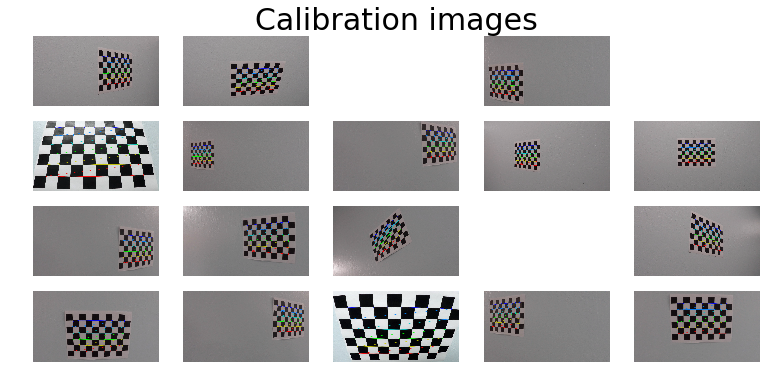

In [2]:
### Extract object points and image points for camera calibration.  

# No. of corners for calibration
nx = 9
ny = 6

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((nx*ny,3), np.float32)
objp[:,:2] = np.mgrid[0:nx, 0:ny].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('./camera_cal/calibration*.jpg')

# Plot calibration images with corners
fig = plt.figure(figsize=(13, 6))
plt.title('Calibration images', fontsize=30)
plt.axis('off')

# Step through the list and search for chessboard corners
for idx, fname in enumerate(images):
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (nx,ny), None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        cv2.drawChessboardCorners(img, (nx,ny), corners, ret)
        
        fig.add_subplot(4, 5, idx+1)
        plt.axis('off')
        plt.imshow(img, cmap='gray')

In [3]:
# Load image for camera calibration
img = cv2.imread('camera_cal/calibration1.jpg')
img_size = (img.shape[1], img.shape[0])

# Calibrate camera with objpoints and imgpoints
# Calculate the camera matrix (mtx) and distortion coefficients (dist)
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)

# Image Distortion

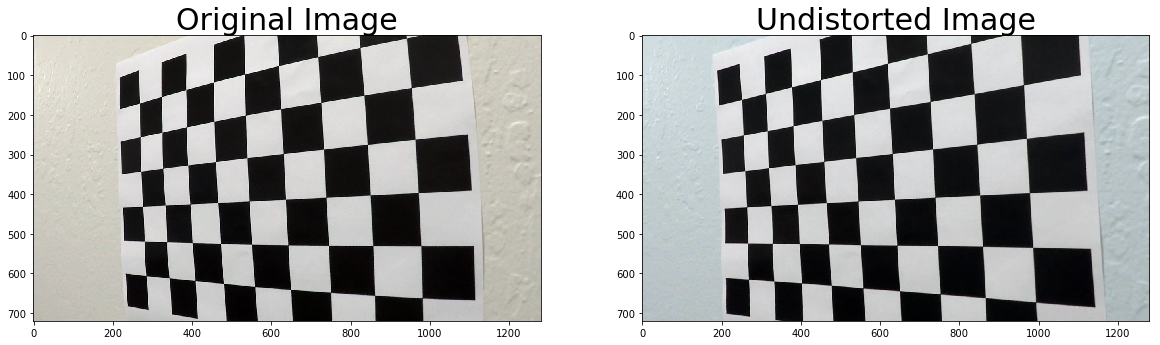

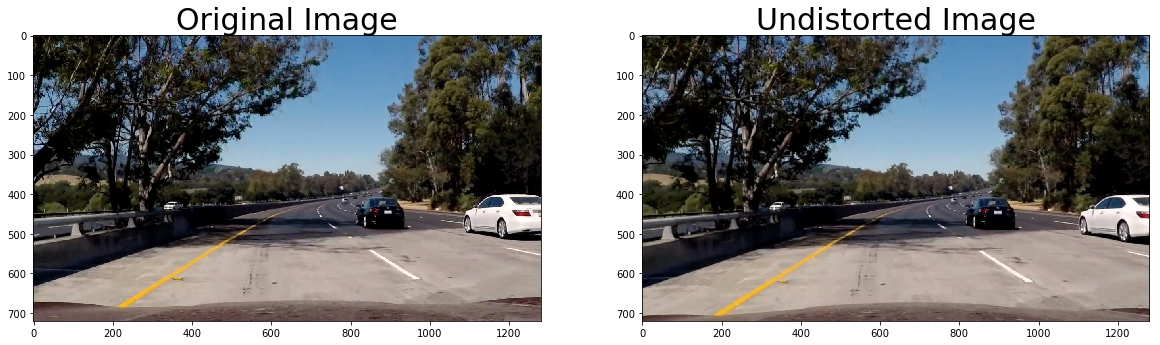

In [4]:
def undistort_image(image):
    """
    Purpose: Takes in a RGB image and returns the undistorted image
    """
    return cv2.undistort(image, mtx, dist, None, mtx)

# Define a test image to use to display image transforms
test_image = cv2.imread('./test_images/test5.jpg')
test_image = cv2.cvtColor(test_image, cv2.COLOR_BGR2RGB)
test_undist = undistort_image(test_image)

img = cv2.imread('camera_cal/calibration4.jpg')
rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(rgb)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(undistort_image(img))
ax2.set_title('Undistorted Image', fontsize=30)
f, (ax3, ax4) = plt.subplots(1, 2, figsize=(20,10))
ax3.imshow(test_image)
ax3.set_title('Original Image', fontsize=30)
ax4.imshow(test_undist)
ax4.set_title('Undistorted Image', fontsize=30)

# Gradient Thresholded Binaries

In [5]:
def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0, 255)):
    """
    Purpose: To calculate the gradient/derivative of an image in the x or y direction
             and return the binary thresholded Sobel image
    """

    # Grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    # Calculate the gradient and it's absolute value
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel))
    elif orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel))

    # Scale to 8-bit (0 - 255) and convert to type = np.uint8
    scaled_sobel = np.uint8(255 * abs_sobel / np.max(abs_sobel))

    # Calculate the binary sobel
    binary_sobel = np.zeros_like(scaled_sobel)
    binary_sobel[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1

    return binary_sobel


def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    """
    Purpose: To calculate the magnitude of the gradient of an image in the x or y direction
             and return the binary thresholded Sobel image
    """
    # Grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    # Calculate the gradient of x and y
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)

    # Calculate the magnitude
    mag_sobel = np.sqrt(sobelx**2 + sobely**2)

    # Scale to 8-bit (0 - 255) and convert to type = np.uint8
    scaled_sobel = np.uint8(255 * mag_sobel / np.max(mag_sobel))

    # Create a binary mask where magnitude thresholds are met
    binary_sobel = np.zeros_like(scaled_sobel)
    binary_sobel[(scaled_sobel >= mag_thresh[0]) & (scaled_sobel <= mag_thresh[1])] = 1

    return binary_sobel


def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    """
    Purpose: To calculate the direction of the gradient of an image in the x or y direction
             and return the binary thresholded Sobel image
    """
    # Grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    # Calculate the gradient and it's absolute value
    abs_sobelx = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel))
    abs_sobely = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel))

    # Calculate the direction of the gradient
    grad_dir = np.arctan2(abs_sobely, abs_sobelx)

    # Create a binary mask where direction thresholds are met
    binary_sobel = np.zeros_like(abs_sobelx)
    binary_sobel[(grad_dir >= thresh[0]) & (grad_dir <= thresh[1])] = 1

    return binary_sobel

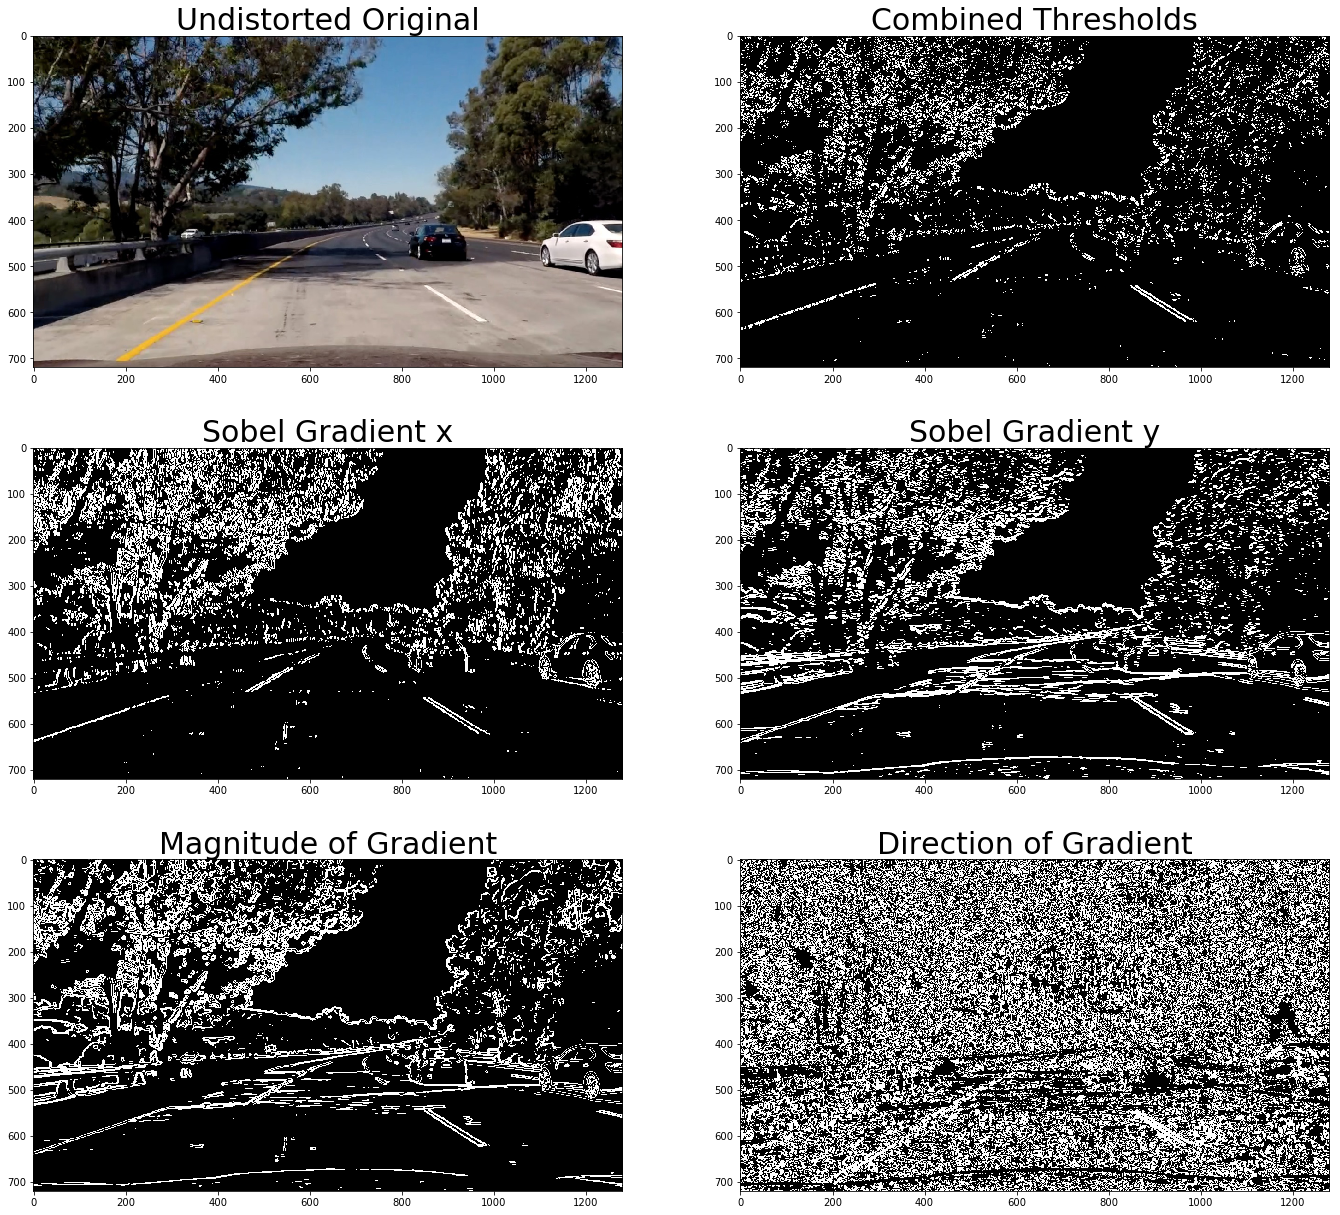

In [6]:
# Choose a Sobel kernel size (odd number)
# A larger number respresents smoother gradient measurements
ksize = 9

# Apply each of the thresholding functions
sxbinary = abs_sobel_thresh(test_undist, orient='x', sobel_kernel=ksize, thresh=(20, 100))
sybinary = abs_sobel_thresh(test_undist, orient='y', sobel_kernel=ksize, thresh=(20, 100))
mag_binary = mag_thresh(test_undist, sobel_kernel=ksize, mag_thresh=(30, 100))
dir_binary = dir_threshold(test_undist, sobel_kernel=ksize, thresh=(0.5, 1.3))

# Combine the thresholds to extract the lane lines
combined = np.zeros_like(dir_binary)
combined[((sxbinary == 1) & (sybinary == 1)) | ((mag_binary == 1) & (dir_binary == 1))
         | ((sxbinary == 1) & (dir_binary == 1))] = 1

# Visualize the results
fig = plt.figure(figsize=(18, 9))

img_list = [[test_undist, 'Undistorted Original'],
            [combined, 'Combined Thresholds'],
            [sxbinary, 'Sobel Gradient x'],
            [sybinary, 'Sobel Gradient y'],
            [mag_binary, 'Magnitude of Gradient'],
            [dir_binary, 'Direction of Gradient']]

rows = 3
cols = 2

for i in range(len(img_list)):
    ax = fig.add_subplot(rows, cols, i+1)
    ax.imshow(img_list[i][0], cmap='gray')
    ax.set_title(img_list[i][1], fontsize=30)

plt.subplots_adjust(left=0., right=1, top=1.8, bottom=0.)

# Color Thresholded Binaries

In [7]:
def R_channel(image, threshold):
    """
    Purpose: To extract the red channel of an image and return the binary thresholded image
    """
    R = image[:,:,0]
    R_binary = np.zeros_like(R)
    R_binary[(R > threshold[0]) & (R <= threshold[1])] = 1
    
    return R_binary


def H_channel(image, threshold):
    """
    Purpose: To extract the Hue channel of an image and return the binary thresholded image
    """
    hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS).astype(np.float)
    H = hls[:,:,0]
    H_binary = np.zeros_like(H)
    H_binary[(H > threshold[0]) & (H <= threshold[1])] = 1

    return H_binary


def S_channel(image, threshold):
    """
    Purpose: To extract the HLS Saturation channel of an image and return the binary thresholded image
    """
    hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS).astype(np.float)
    S = hls[:,:,2]
    S_binary = np.zeros_like(S)
    S_binary[(S > threshold[0]) & (S <= threshold[1])] = 1

    return S_binary

def S2_channel(image, threshold):
    """
    Purpose: To extract the HSV Saturation channel of an image and return the binary thresholded image
    """
    hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV).astype(np.float)
    S2 = hsv[:,:,1]
    S2_binary = np.zeros_like(S2)
    S2_binary[(S2 > threshold[0]) & (S2 <= threshold[1])] = 1

    return S2_binary

def L_channel(image, threshold):
    """
    Purpose: To extract the Saturation channel of an image and return the binary thresholded image
    """
    hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS).astype(np.float)
    L = hls[:,:,1]
    L_binary = np.zeros_like(L)
    L_binary[(L > threshold[0]) & (L <= threshold[1])] = 1

    return L_binary

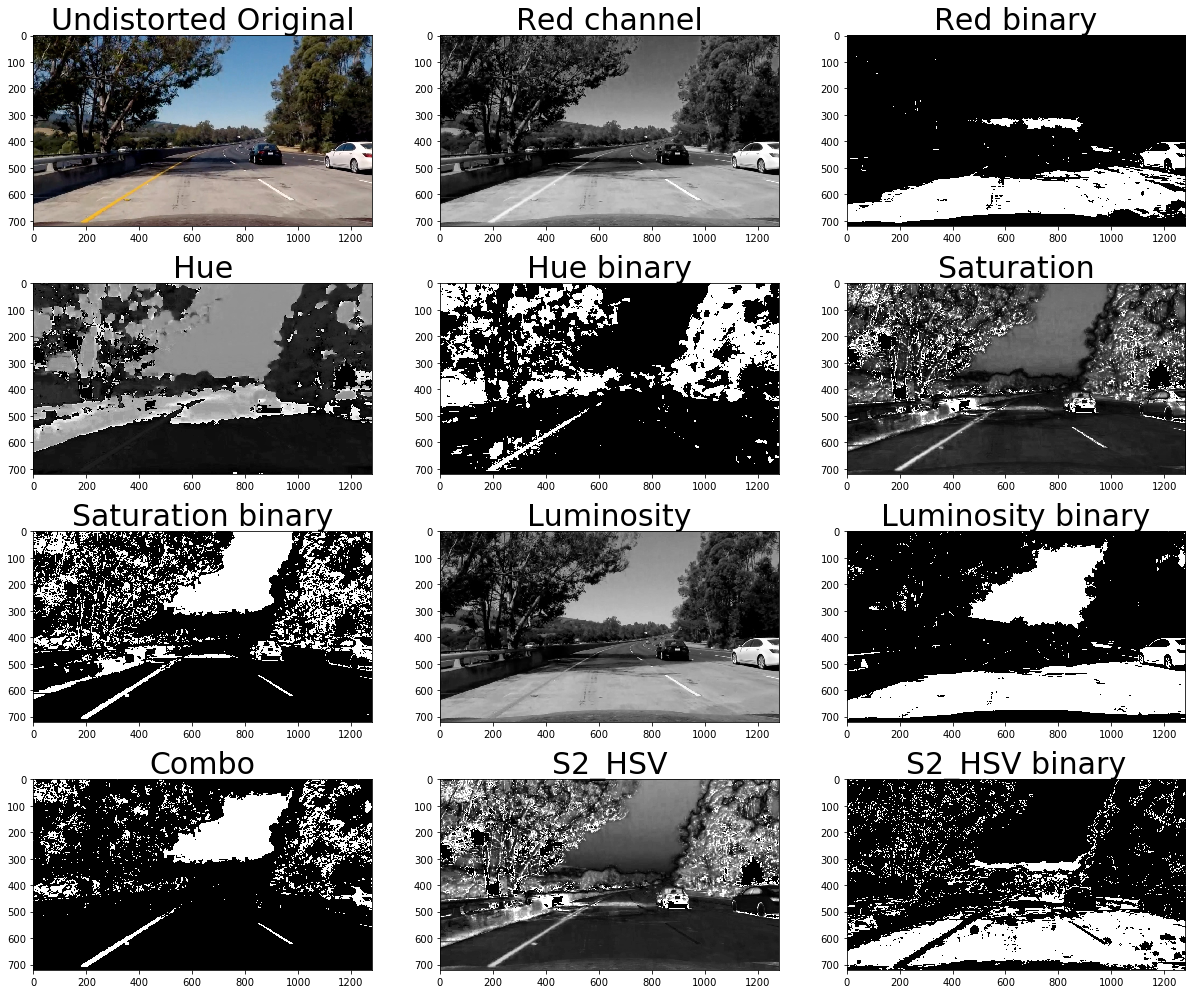

In [8]:
# Red channel
R = test_undist[:,:,0]
R_threshold = (170, 255)
R_binary = R_channel(test_undist, R_threshold)

# Hue channel - the lane lines appear dark so try a low threshold
hls = cv2.cvtColor(test_undist, cv2.COLOR_RGB2HLS).astype(np.float)
H = hls[:,:,0]
H_threshold = (16, 100)
H_binary = H_channel(test_undist, H_threshold)

# Luminosity channel
L = hls[:,:,1]
L_threshold = (140, 255)
L_binary = L_channel(test_undist, L_threshold)

# Saturation channel from HLS
S = hls[:,:,2]
S_threshold = (90, 255)
S_binary = S_channel(test_undist, S_threshold)

# Saturation channel from HSV
hsv = cv2.cvtColor(test_undist, cv2.COLOR_RGB2HSV).astype(np.float)
S2 = hsv[:,:,1]
S2_threshold = (30, 50)
S2_binary = S2_channel(test_undist, S2_threshold)

combo = np.zeros_like(S_binary)
combo[((S_binary == 1) & ((H_binary == 1) | (R_binary == 1) | (L_binary == 1)))] = 1


# Visualize results
fig = plt.figure(figsize=(16, 6))

img_list = [[test_undist, 'Undistorted Original'],
            [R, 'Red channel'],
            [R_binary, 'Red binary'],
            [H, 'Hue'],
            [H_binary, 'Hue binary'],
            [S, 'Saturation'],
            [S_binary, 'Saturation binary'],
            [L, 'Luminosity'],
            [L_binary, 'Luminosity binary'],
            [combo, 'Combo'],
            [S2, 'S2_HSV'],
            [S2_binary, 'S2_HSV binary']]

rows = 4
cols = 3

for i in range(len(img_list)):
    ax = fig.add_subplot(rows, cols, i+1)
    ax.imshow(img_list[i][0], cmap='gray')
    ax.set_title(img_list[i][1], fontsize=30)

plt.subplots_adjust(left=0., right=1, top=1.8, bottom=-0.4)

# Gradient + Color Combination

In [9]:
# Combine the Gradient and Color binary threshold images
def combination(image):
    """
    Purpose: To combine the Gradient and Color binary thresholded images
             and return the combined binary image
    """
    # Stack - Gradient threshold in green, Color threshold in blue
    color_binary = np.dstack((np.zeros_like(combined), combined, combo))

    # Combined
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[(combined == 1) | (combo == 1)] = 1

    return color_binary, combined_binary

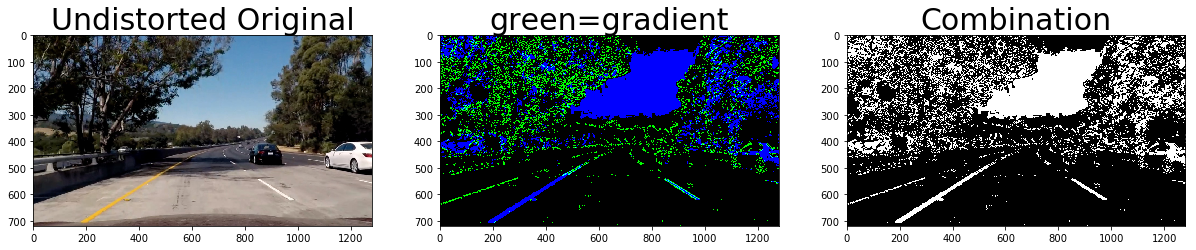

In [10]:
# Generated the color & combined binary images
color_binary, combined_binary = combination(test_undist)

# Visualize results
fig = plt.figure(figsize=(16, 6))

img_list = [[test_undist, 'Undistorted Original'],
            [color_binary, 'green=gradient'],
            [combined_binary, 'Combination']]
rows = 1
cols = 3

for i in range(len(img_list)):
    ax = fig.add_subplot(rows, cols, i+1)
    ax.imshow(img_list[i][0], cmap='gray')
    ax.set_title(img_list[i][1], fontsize=30)

plt.subplots_adjust(left=0., right=1, top=1.8, bottom=0.)

# Perspective Transform

In [11]:
def src_dst(img):
    """
    Purpose: To define the source and destination quadrangle vertices

    Note: This only needs to be run once

    Outputs: src - the vertices of the input image trapezium
             dst - the vertices of the output image square
    """
    # Get the shape of the imput image
    y = img.shape[0]
    x = img.shape[1]

    # Define the source trapezium around the expected lane line area
    src = np.float32([[x*0.43, y*0.67],     # top left
                     [x*0.58, y*0.67],      # top right
                     [x*0.85, y*0.98],      # bottom right
                     [x*0.17, y*0.98]])     # bottom left

    
    # Destination points
    dst = np.float32([[200, 0],        # top left
                      [x-200, 0],      # top right
                      [x-200, y],      # bottom right
                      [200, y]])       # bottom left

    return src, dst


def perspective_map(image, src, dst):
    """
    Purpose: To define the Perspective Transform of the input image according to the
             input source and destination points
    
    Outputs: Minv - the inverse Perspective Mapping
             warped - the resultant transformation of the input image to a "top-down" view
    """
    # Get the shape of the imput image
    y = img.shape[0]
    x = img.shape[1]

    # Get transform matrix
    M = cv2.getPerspectiveTransform(src, dst)

    # Get inverse transform matrix
    Minv = cv2.getPerspectiveTransform(dst, src)

    # Warp to top down view
    warped = cv2.warpPerspective(image, M, (x, y), flags=cv2.INTER_LINEAR)

    return Minv, warped


def region_of_interest(img):
    """
    Purpose: To draw the trapezium over the image
             This is the area which will be transformed into a "birds eye" view
    """
    # Get the shape of the imput image
    y = img.shape[0]
    x = img.shape[1]

    # Points for drawing the trapezium
    pts = np.array([[x*0.43, y*0.67],
                    [x*0.58, y*0.67],
                    [x*0.85, y*0.98],
                    [x*0.17, y*0.98]],
                  np.int32)

    pts = pts.reshape((-1,1,2))
    
    return cv2.polylines(img, [pts], True, (0,255,0), thickness=3)

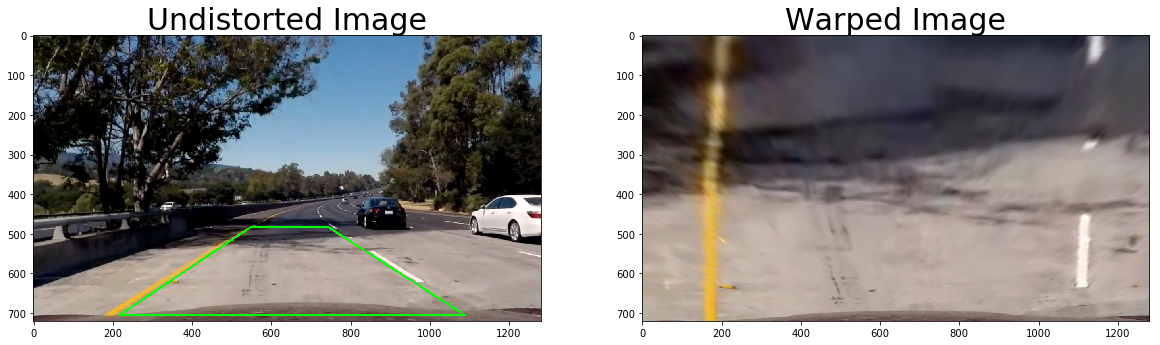

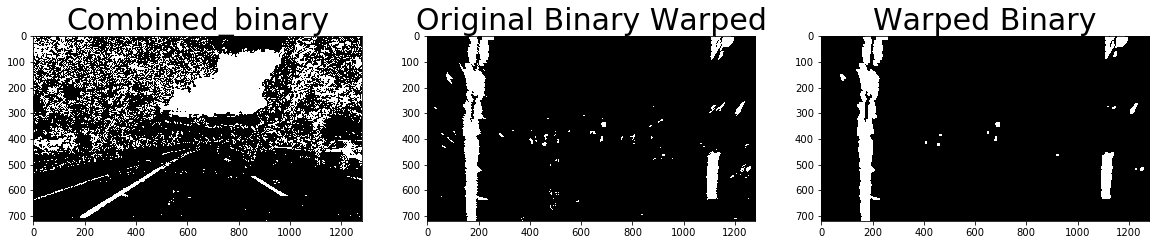

In [12]:
# Obtain the source and destination points
src, dst = src_dst(test_undist)

test_undist_trap = np.copy(test_undist)
trapezium = region_of_interest(test_undist_trap)

Minv_test, warped = perspective_map(test_undist, src, dst)

Minv, noisy_warped = perspective_map(combined_binary, src, dst)

# Clearing noise in binary_warped
small_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (7, 7))
binary_warped = cv2.morphologyEx(noisy_warped, cv2.MORPH_OPEN, small_kernel)

# Visualize warped image
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(trapezium)
ax1.set_title('Undistorted Image', fontsize=30)
ax2.imshow(warped)
ax2.set_title('Warped Image', fontsize=30)

f, (ax3, ax4, ax5) = plt.subplots(1, 3, figsize=(20,10))
ax3.imshow(combined_binary, cmap='gray')
ax3.set_title('Combined_binary', fontsize=30)
ax4.imshow(noisy_warped, cmap='gray')
ax4.set_title('Original Binary Warped', fontsize=30)
ax5.imshow(binary_warped, cmap='gray')
ax5.set_title('Warped Binary', fontsize=30)

# Class Line()

In [13]:
# Define a class to keep track of past variables
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False

        # x values of the last n fits of the line
        self.recent_xfitted = []

        # average x values of the fitted line over the last n iterations
        self.bestx = None

        # polynomial coefficients averaged over the last n iterations
        self.best_fit = []

        # polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]

        # radius of curvature of the line in some units
        self.radius_of_curvature = []

        # distance in meters of vehicle center from the line
        self.line_base_pos = []

        # difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float')

        # x values for detected line pixels
        self.allx = None

        # y values for detected line pixels
        self.ally = None

# Define a lane line class for the left and right lane
llane = Line()
rlane = Line()

# Histogram

In [14]:
def get_hist(image):
    """
    Purpose: Take histogram of bottom half of image, all columns and one channel.
             Histogram should clearly indicate the lane lines.
    
    Input: A binary thresholded, warped image (ie top-down perspective).
    
    Output: The maximum value on the left and right halves of the histogram, assuming
            that these are the x positions of the base of the left and right lane lines
    """
    histogram = np.sum(image[np.int(image.shape[0]/2):,:], axis=0)

    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    return leftx_base, rightx_base

calculated left_base 160
calculated right_base 1106


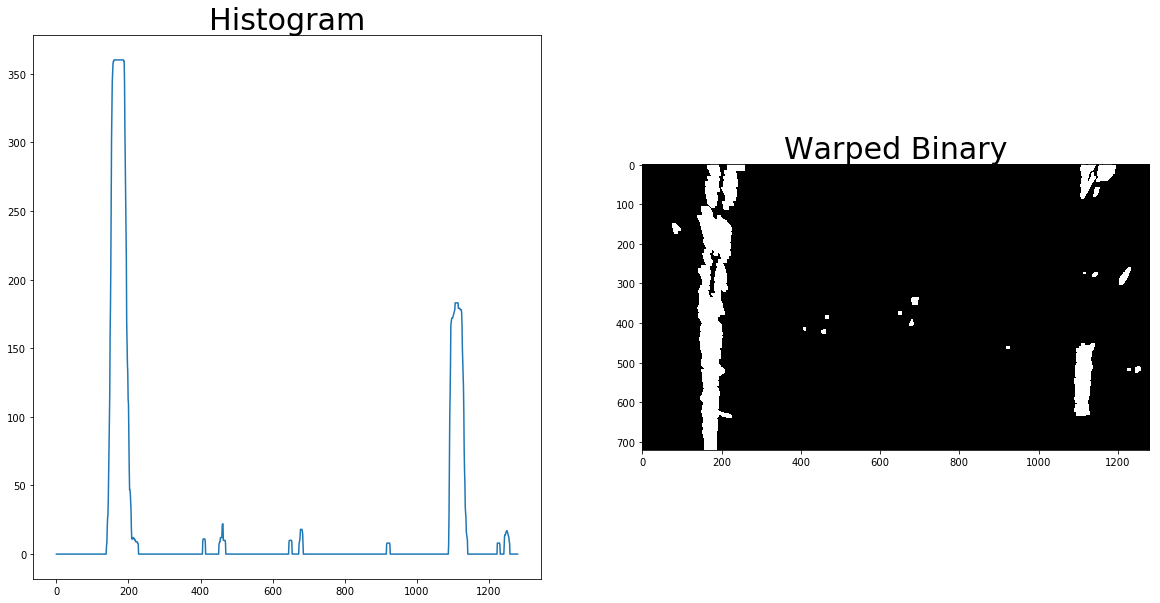

In [15]:
"""
leftx_base: The assumed base of the left lane line
rightx_base: The assumed base of the right lane line
"""
leftx_base, rightx_base = get_hist(binary_warped)

histogram = np.sum(binary_warped[np.int(binary_warped.shape[0]/2):,:], axis=0)

print('calculated left_base', leftx_base)
print('calculated right_base', rightx_base)

# Visualize images
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.plot(histogram)
ax1.set_title('Histogram', fontsize=30)
ax2.imshow(binary_warped, cmap='gray')
ax2.set_title('Warped Binary', fontsize=30)

# Lane Detection

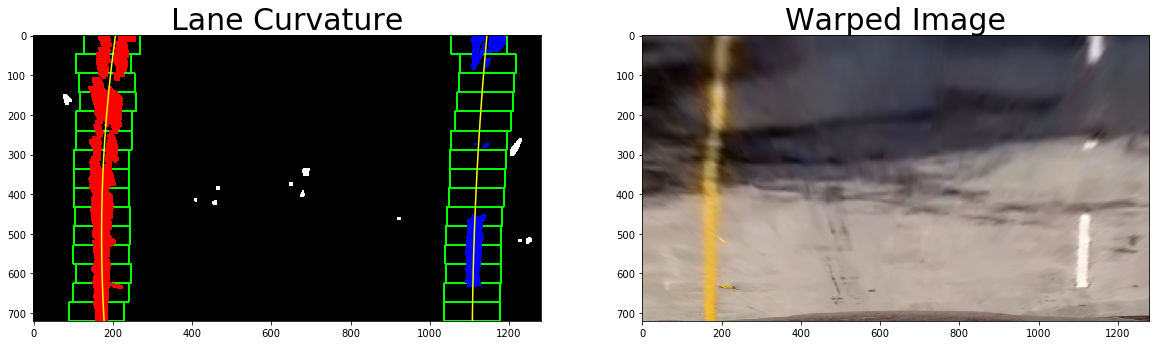

In [16]:
def get_poly_first_image(binary_warped, leftx_base, rightx_base):
    """
    Purpose: To implement Sliding Windows and Fit a Polynomial to the first video image

    Input: Binary warped image
    
    Output: Binary warped image with windows and lanes

    Strategy:
    - Divide the image height into equally spaced rows
    - Define a window in each row
    - Center the first window around the base of each lane as determined in the histogram
    - Count the number of pixels inside each window
    - If greater than minpix, center each window around the mean of all the pixels inside the window
    - Get all the pixels inside the windows (leftx and lefty...)
    - Get the binomial coefficients of the curve that fits all the pixels in the windows (left_fit)
    - Define the coordinates of the lane line curve (left_fitx, ploty)
    """
    # Choose the number of sliding windows
    nwindows = 15
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Set the width of the windows +/- margin
    margin = 70
    # Set minimum number of pixels found to re-center window
    minpix = 50
    # Define list of windows movements
    lwin_list = []
    dlwin_list = []
    rwin_list = []
    drwin_list = []

    # Create an output image to draw on and visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255

    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), thickness=4)
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), thickness=4)
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high)
                          & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high)
                           & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)

        # Append the base position to win_list
        lwin_list.append(leftx_current)
        rwin_list.append(rightx_current)
        # Append the delta increment to dwin_list
        if len(lwin_list) > 1:
            dlwin_list.append(lwin_list[-1] - lwin_list[-2])
            drwin_list.append(rwin_list[-1] - rwin_list[-2])

        # If found > minpix pixels, re-center the next window to the mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        # If found < minpix pixels, examine dwin_list for previous movements and move accordingly
        else:
            dlwin_avg = sum(dlwin_list[-5:]) / 5
            leftx_current = int(leftx_current + dlwin_avg)
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
        else:
            drwin_avg = sum(drwin_list[-5:]) / 5
            rightx_current = int(rightx_current + drwin_avg)

    # Concatenate the arrays of indices
    # left_lane_inds is the list of all indices of pixels in all the windows
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds]
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    # If points are detected in the left or right lanes, update self.allx and self.ally
    # If points aren't detected, don't update
    # Left lane
    if (leftx.size == 0) | (lefty.size == 0):
        llane.detected = False
    else:
        llane.detected = True
        llane.allx = leftx
        llane.ally = lefty
    # Right lane
    if (rightx.size == 0) | (righty.size == 0):
        rlane.detected = False
    else:
        rlane.detected = True
        rlane.allx = rightx
        rlane.ally = righty

    # Fit a second order polynomial to each
    left_fit = np.polyfit(llane.ally, llane.allx, 2)
    right_fit = np.polyfit(rlane.ally, rlane.allx, 2)

    # Update the current coefficients
    p = 1
    if len(llane.best_fit) > 1:
        llane.current_fit = (p*left_fit) + ((1-p)*(sum(llane.best_fit)/len(llane.best_fit)))
        rlane.current_fit = (p*right_fit) + ((1-p)*(sum(rlane.best_fit)/len(rlane.best_fit)))
    else:
        llane.current_fit = left_fit
        rlane.current_fit = right_fit

    # Update the coefficient list
    llane.best_fit.append(left_fit)
    rlane.best_fit.append(right_fit)

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = llane.current_fit[0]*ploty**2 + llane.current_fit[1]*ploty + llane.current_fit[2]
    right_fitx = rlane.current_fit[0]*ploty**2 + rlane.current_fit[1]*ploty + rlane.current_fit[2]
    # Store the fitx values in the class for averaging purposes
    llane.recent_xfitted.insert(0, left_fitx)
    rlane.recent_xfitted.insert(0, right_fitx)

    return out_img, ploty



### Visualize the result

out_img, ploty = get_poly_first_image(binary_warped, leftx_base, rightx_base)

# Plot each pixel in the windows to a color
out_img[llane.ally, llane.allx] = [255, 0, 0]
out_img[rlane.ally, rlane.allx] = [0, 0, 255]
# Display output image with windows and colored pixels
# Plot the lane curve onto the output image
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(out_img)
ax1.set_title('Lane Curvature', fontsize=30)
ax1.plot(llane.recent_xfitted[0], ploty, color='yellow')
ax1.plot(rlane.recent_xfitted[0], ploty, color='yellow')
ax2.imshow(warped)
ax2.set_title('Warped Image', fontsize=30)

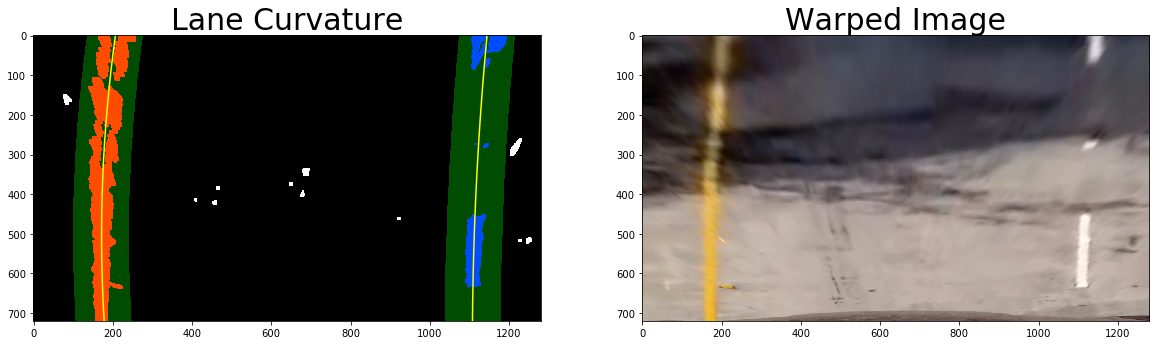

In [17]:
def get_poly_subs_image(binary_warped):
    """
    Purpose: To fit a polynomial to all but the first image

    Input: Binary warped image
    
    Ouput: None

    Strategy:
    - Follow the strategy above but skip the window definition step.
      Use the curve from the previous image
    """
    # Set the width of the curve +/- margin
    margin = 70

    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])

    # Caluculate the curve values
    left_curve_vals = llane.current_fit[0]*(nonzeroy**2) + llane.current_fit[1]*nonzeroy + llane.current_fit[2]
    right_curve_vals = rlane.current_fit[0]*(nonzeroy**2) + rlane.current_fit[1]*nonzeroy + rlane.current_fit[2]

    # left_lane_inds is the list of all indices between the curve +- margin
    left_lane_inds = ((nonzerox > (left_curve_vals - margin))
                      & (nonzerox < (left_curve_vals + margin))) 
    right_lane_inds = ((nonzerox > (right_curve_vals - margin))
                       & (nonzerox < (right_curve_vals + margin)))  

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds]
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    # If points are detected in the left or right lanes, update self.allx and self.ally
    # If points aren't detected, don't update
    # Left lane
    if (leftx.size == 0) | (lefty.size == 0):
        llane.detected = False
    else:
        llane.detected = True
        llane.allx = leftx
        llane.ally = lefty
    # Right lane
    if (rightx.size == 0) | (righty.size == 0):
        rlane.detected = False
    else:
        rlane.detected = True
        rlane.allx = rightx
        rlane.ally = righty

    # Define limit - if the number of detected pixels is below a threshold,
    # run sliding windows on the next image.
    thresh = 5000
    if len(llane.allx) < thresh:
        llane.detected = False
    if len(rlane.allx) < thresh:
        rlane.detected = False

    # Fit a second order polynomial to each
    left_fit = np.polyfit(llane.ally, llane.allx, 2)
    right_fit = np.polyfit(rlane.ally, rlane.allx, 2)

    # Update the current coefficients
    p = 0.7
    if len(llane.best_fit) > 1:
        llane.current_fit = (p*left_fit) + ((1-p)*(sum(llane.best_fit)/len(llane.best_fit)))
        rlane.current_fit = (p*right_fit) + ((1-p)*(sum(rlane.best_fit)/len(rlane.best_fit)))
    else:
        llane.current_fit = left_fit
        rlane.current_fit = right_fit

    # Update the coefficient list
    llane.best_fit.append(left_fit)
    rlane.best_fit.append(right_fit)

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = llane.current_fit[0]*ploty**2 + llane.current_fit[1]*ploty + llane.current_fit[2]
    right_fitx = rlane.current_fit[0]*ploty**2 + rlane.current_fit[1]*ploty + rlane.current_fit[2]
    # Store the fitx values in the class for averaging purposes
    llane.recent_xfitted.insert(0, left_fitx)
    rlane.recent_xfitted.insert(0, right_fitx)

    return ploty



### Visualize the result

ploty = get_poly_subs_image(binary_warped)

# Create an image to draw on and an image to show the selection window
out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
window_img = np.zeros_like(out_img)
# Color in left and right line pixels
out_img[llane.ally, llane.allx] = [255, 0, 0]
out_img[rlane.ally, rlane.allx] = [0, 0, 255]

# Generate a polygon to illustrate the search window area
# And recast the x and y points into usable format for cv2.fillPoly()
margin = 70
left_line_window1 = np.array([np.transpose(np.vstack([llane.recent_xfitted[0]-margin, ploty]))])
left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([llane.recent_xfitted[0]+margin, ploty])))])
left_line_pts = np.hstack((left_line_window1, left_line_window2))
right_line_window1 = np.array([np.transpose(np.vstack([rlane.recent_xfitted[0]-margin, ploty]))])
right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([rlane.recent_xfitted[0]+margin, ploty])))])
right_line_pts = np.hstack((right_line_window1, right_line_window2))

# Draw the lane onto the warped blank image
cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(result)
ax1.set_title('Lane Curvature', fontsize=30)
ax1.plot(llane.recent_xfitted[0], ploty, color='yellow')
ax1.plot(rlane.recent_xfitted[0], ploty, color='yellow')
ax2.imshow(warped)
ax2.set_title('Warped Image', fontsize=30)

# Radius of Curvature

In [18]:
def rad_of_curv(image, ploty):
    """
    Purpose: To calculate the radius of curvature of the lane line in real world space (m).
             To calculate the distance of the car left of the center of the lane in meters

    Equation: Rcurve = ((1 + (2*A + B)**2)**1.5) / np.absolute(2*A)

    Input: Undistorted image used to determine where the radius must be measured
           ploty

    Strategy:
    - Choose a point on the y-axis where you want to measure the radius of curvature
    - Assume: lane length = 30m
              lane width = 3.7m
    - Calculate the binomial coefficients in real world space
    - Calculate the radius, in meters, using the equation above
    - Calculate the distance of the car left of the center of the lane in meters
    """
    # Define y-eval as the bottom of the image, where we want to measure the radius of curvature
    y_eval = np.max(ploty)

    # Calculate distance between lane lines bases
    # The polynomial x value the bottom of the image is used to determine the cars position
    dist = rlane.recent_xfitted[0][y_eval] - llane.recent_xfitted[0][y_eval]

    # Define conversions in x and y from pixel space to meters
    ym_per_pix = 30 / image.shape[0]
    xm_per_pix = 3.7 / dist
    
    # Fit new polynomials to x and y in real world space
    real_left_coeffs = np.polyfit(ploty*ym_per_pix, llane.recent_xfitted[0]*xm_per_pix, 2)
    real_right_coeffs = np.polyfit(ploty*ym_per_pix, rlane.recent_xfitted[0]*xm_per_pix, 2)

    # Calculate the radii of curvature in meters
    l_rad = (((1 + (2*real_left_coeffs[0]*y_eval*ym_per_pix + real_left_coeffs[1])**2)**1.5)
             / np.absolute(2*real_left_coeffs[0]))
    r_rad = (((1 + (2*real_right_coeffs[0]*y_eval*ym_per_pix + real_right_coeffs[1])**2)**1.5)
             / np.absolute(2*real_right_coeffs[0]))

    # Insert the radius for averaging
    llane.radius_of_curvature.insert(0, l_rad)
    rlane.radius_of_curvature.insert(0, r_rad)

    # Calculate the distance of the car left of the center of the lane in meters
    car_pos = image.shape[1] / 2
    lane_center = llane.recent_xfitted[0][y_eval] + (dist/2)
    offcenter = (lane_center - car_pos) * xm_per_pix
    
    # Insert offcenter values for averaging
    llane.line_base_pos.insert(0, offcenter)

rad_of_curv(binary_warped, ploty)
print('Radius of Curvature - Left: {:.1f}m'.format(llane.radius_of_curvature[0]))
print('Radius of Curvature - Right: {:.1f}m'.format(rlane.radius_of_curvature[0]))
print('Distance left of center: {:.2f}m'.format(llane.line_base_pos[0]))

Radius of Curvature - Left: 1592.4m
Radius of Curvature - Right: 3625.2m
Distance left of center: 0.01m


# Warp to Original Image

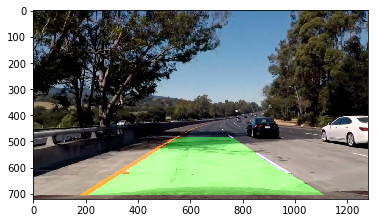

In [19]:
def unwarp(binary_warped, undist, ploty, Minv):
    """
    Purpose: Unwarp the binary image and display the detected lane over the original image

    Input: binary warped image, undistorted original image
           ploty, Minv

    Output: Unwarped image with superimposed lane lines and detected lane
    """
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([llane.recent_xfitted[0], ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([rlane.recent_xfitted[0], ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0, 255, 0))

    # Draw lines onto color_warp
    color_warp[llane.ally, llane.allx] = [255, 0, 0]
    color_warp[rlane.ally, rlane.allx] = [0, 0, 255]

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (binary_warped.shape[1], binary_warped.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(undist, 1, newwarp, 0.4, 0)

    return result

new_image = unwarp(binary_warped, test_undist, ploty, Minv)
plt.imshow(new_image)

# Advanced Lane Finding Method

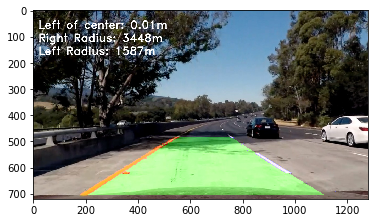

In [20]:
"""
This is the main cell that processes each image
"""

def add_lanes_to_image(image):
    # Udistort a RGB image
    undist = undistort_image(image)

    # Apply a combination of gradient and color filters to the undistorted image
    # and return a binary thresholded image
    # Get sobel thresholded binaries
    ksize = 9
    sxbinary = abs_sobel_thresh(undist, orient='x', sobel_kernel=ksize, thresh=(20, 100))
    sybinary = abs_sobel_thresh(undist, orient='y', sobel_kernel=ksize, thresh=(20, 100))
    mag_binary = mag_thresh(undist, sobel_kernel=ksize, mag_thresh=(30, 100))
    dir_binary = dir_threshold(undist, sobel_kernel=ksize, thresh=(0.5, 1.3))
    # Combine the sobel thresholded binaries to extract the lane lines
    combined = np.zeros_like(sxbinary)
    combined[((sxbinary == 1) & (sybinary == 1)) | ((mag_binary == 1) & (dir_binary == 1))
             | ((sxbinary == 1) & (dir_binary == 1))] = 1
    
    # Get R_binary
    R_threshold = (170, 255)
    R_binary = R_channel(undist, R_threshold)
    # Get H_binary
    H_threshold = (16, 100)
    H_binary = H_channel(undist, H_threshold)
    # Get L_binary
    L_threshold = (140, 255)
    L_binary = L_channel(undist, L_threshold)
    # Get S_binary
    S_threshold = (90, 255)
    S_binary = S_channel(undist, S_threshold)
    # Combine color channels
    combo = np.zeros_like(S_binary)
    combo[((S_binary == 1) & ((H_binary == 1) | (R_binary == 1) | (L_binary == 1)))] = 1

    # Combine them
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[(combined == 1) | (combo == 1)] = 1

    # Calculate the source and destination points on the image
    src, dst = src_dst(combined_binary)
    # Do a perspective transform to the "top-down" view
    Minv, binary_warped = perspective_map(combined_binary, src, dst)

    if llane.detected == False:
        # This is the first image or a lane was not detected correctly
        # Get the base of the left and right lanes from the histogram of the binary warped image
        leftx_base, rightx_base = get_hist(binary_warped)
        # Implement sliding windows and fit a polynomial
        out_img, ploty = get_poly_first_image(binary_warped, leftx_base, rightx_base)
    else:
        # These are subsequent images
        # Calculate the polynomial coefficients
        ploty = get_poly_subs_image(binary_warped)

    # Trim list to last n values
    n = 5
    # x-values of last n left and right curves
    if len(llane.recent_xfitted) > n:
        del llane.recent_xfitted[n:]
    if len(rlane.recent_xfitted) > n:
        del rlane.recent_xfitted[n:]
    # Last n left and right lane radii of curvature
    if len(llane.radius_of_curvature) > n:
        del llane.radius_of_curvature[n:]
    if len(rlane.radius_of_curvature) > n:
        del rlane.radius_of_curvature[n:]
    # Last n left-of-center offests
    if len(llane.line_base_pos) > n:
        del llane.line_base_pos[n:]
    # Last n/2 polynomial coefficients
    if len(llane.best_fit) > 3:
        del llane.best_fit[3:]
    if len(rlane.best_fit) > 3:
        del rlane.best_fit[3:]

    # Calculate the radius of curvature in meters
    rad_of_curv(undist, ploty)

    # Produce the resultant processed image
    processed_image = unwarp(binary_warped, undist, ploty, Minv)

    # Calculate and display an averaged radius of curvature
    # averaging left
    left_smooth_radius = sum(llane.radius_of_curvature) / len(llane.radius_of_curvature)
    cv2.putText(processed_image, 'Left Radius: {:.0f}m'.format(left_smooth_radius), (20,170),
                cv2.FONT_HERSHEY_DUPLEX, 1.4, (255,255,255), 2, cv2.LINE_AA, False)
    
    # averaging right
    right_smooth_radius = sum(rlane.radius_of_curvature) / len(rlane.radius_of_curvature)
    cv2.putText(processed_image, 'Right Radius: {:.0f}m'.format(right_smooth_radius), (20,120),
                cv2.FONT_HERSHEY_DUPLEX, 1.4, (255,255,255), 2, cv2.LINE_AA, False)

    # Calculate and display an averaged distance of car left of center of lane
    smooth_offset = sum(llane.line_base_pos) / len(llane.line_base_pos)
    cv2.putText(processed_image, 'Left of center: {:.2f}m'.format(smooth_offset), (20,70),
                cv2.FONT_HERSHEY_DUPLEX, 1.4, (255,255,255), 2, cv2.LINE_AA, False)

    return processed_image

# Test an image
new_image = add_lanes_to_image(test_image)
plt.imshow(new_image)

In [21]:
def process_image(image):
    result = add_lanes_to_image(image)

    return result

# Project Video

In [22]:
### project_video

# Define a lane line class for the left and right lane
llane = Line()
rlane = Line()

# Input the video, runs each image through 'process_image' and saves the new video
video_output = 'project_output.mp4'
clip1 = VideoFileClip("./project_video.mp4")
clip2 = clip1.fl_image(process_image)
%time clip2.write_videofile(video_output, audio=False)

[MoviePy] >>>> Building video project_output.mp4
[MoviePy] Writing video project_output.mp4


100%|█████████▉| 1260/1261 [07:31<00:00,  2.66it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_output.mp4 

CPU times: user 19min 11s, sys: 18.4 s, total: 19min 29s
Wall time: 7min 33s


# Challenge Video

In [ ]:
### challenge_video

# Define a lane line class for the left and right lane
llane = Line()
rlane = Line()

# Input the video, runs each image through 'process_image' and saves the new video
video_output = 'challenge_output.mp4'
clip1 = VideoFileClip("./challenge_video.mp4")
clip2 = clip1.fl_image(process_image)
%time clip2.write_videofile(video_output, audio=False)

[MoviePy] >>>> Building video challenge_output.mp4
[MoviePy] Writing video challenge_output.mp4


100%|██████████| 485/485 [02:53<00:00,  2.99it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: challenge_output.mp4 

CPU times: user 7min 21s, sys: 6.75 s, total: 7min 27s
Wall time: 2min 53s


# Harder Challenge Video

In [ ]:
### harder_challenge_video

# Define a lane line class for the left and right lane
llane = Line()
rlane = Line()

# Input the video, runs each image through 'process_image' and saves the new video
video_output = 'harder_challenge_output.mp4'
clip1 = VideoFileClip("./harder_challenge_video.mp4")
clip2 = clip1.fl_image(process_image)
%time clip2.write_videofile(video_output, audio=False)

[MoviePy] >>>> Building video harder_challenge_output.mp4
[MoviePy] Writing video harder_challenge_output.mp4


 98%|█████████▊| 1171/1200 [07:05<00:11,  2.47it/s]